In [173]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [174]:
rng = np.random.default_rng()

E1 = 8.4736 # MeV
dE = 0.8 # MeV (energy bin width)
avg_background_rate = 0.28*dE # hits/sec in bin
signal_rate = 0.5020674300000211e-3 # hits/sec (delta fxn)
fourweeks = 3600*24*28 # 4 weeks in seconds

1214


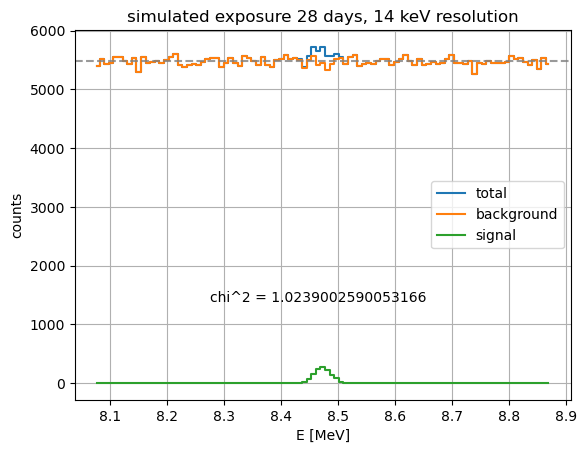

In [234]:
class Resolution:

    def __init__(self, sigma, B = avg_background_rate/signal_rate, dE = dE, N = 1000_000, Nbins = 100):
        self.sigma = sigma # resolution of delta-fxn peak
        self.B = B # background rate (relative to signal rate)
        self.dE = dE # width of energy ROI
        self.N_signal = N # number of signal events to sample in ROI
        self.N_background = int(N*B)
        self.E1 = 8.4736 # MeV
        self.exposure_time = self.N_signal/signal_rate # sec
        self.Nbins = Nbins

    def generate_signal(self):
        self.signal = rng.normal(loc = E1, scale = self.sigma, size = self.N_signal)
    
    def generate_background(self):
        self.background = self.E1 + self.dE*(rng.uniform(size = self.N_background) - 0.5)


    def analyze(self):
        self.generate_signal()
        self.generate_background()

        # bin edges
        self.Ebins = np.linspace(E1 - self.dE/2, E1 + self.dE/2, self.Nbins)
        # bin centers
        self.Es = (self.Ebins[1:] + self.Ebins[:-1])/2 
        # bin widths
        self.dEs = np.diff(self.Ebins)

        self.signal_hist, _ = np.histogram(self.signal, bins = self.Ebins)
        self.background_hist, _ = np.histogram(self.background, bins = self.Ebins)
        self.hist = self.signal_hist + self.background_hist

        self.mean = self.hist.sum()
        self.expec = self.mean/(self.Nbins-1)

        self.chi2 = (((self.hist - self.expec)**2)/self.expec).sum()/self.Nbins


    def histogram(self, **kwargs):
        plt.figure()
        plt.grid()

        plt.xlabel('E [MeV]')
        plt.ylabel('counts')
        plt.title(f'simulated exposure {self.exposure_time/3600/24:.2g} days, {self.sigma*1e3:.2g} keV resolution')

        plt.step(self.Es, self.hist, where = 'mid', label = 'total')

        plt.step(self.Es, self.background_hist, where = 'mid', label = 'background')
        plt.step(self.Es, self.signal_hist, where = 'mid', label = 'signal')
        plt.legend()

        plt.text(self.Ebins[self.Nbins//4], self.hist[self.Nbins//4]/4, f'chi^2 = {self.chi2}')

        plt.axhline(self.expec, color = 'grey', linestyle = 'dashed', alpha = 0.8)



tr = Resolution(E1/600, N = int(signal_rate*fourweeks))
tr.analyze()

tr.histogram()

print(tr.N_signal)

In [181]:
Ntrials = 1000
best_resolution = 5000
worst_resolution = 40
sigmas = E1*np.exp(np.log(1/best_resolution) + (np.log(1/worst_resolution) - np.log(1/best_resolution))*rng.random(size = Ntrials))
chis = np.zeros(sigmas.shape)

for i, sigma in enumerate(tqdm.tqdm(sigmas)):
    res = Resolution(sigma, N = int(signal_rate*fourweeks))
    res.analyze()
    chis[i] = res.chi2


100%|██████████| 1000/1000 [00:26<00:00, 37.54it/s]


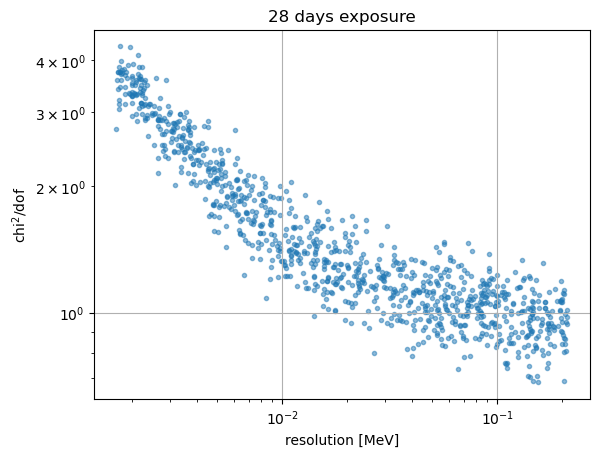

In [182]:
plt.figure()
plt.grid()
plt.loglog()
plt.title('28 days exposure')
plt.xlabel('resolution [MeV]')
plt.ylabel('chi$^2$/dof')
plt.scatter(sigmas, chis, marker = '.', alpha = 0.5)